In [15]:
###-----------------
### Import Libraries
###-----------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn import datasets
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
%matplotlib inline

In [16]:
###----------------
### Some parameters
###----------------

Sharma_sir_state = 24 # REMEMBER: to remove at the time of promotion to production
np.random.seed(Sharma_sir_state)
rng = np.random.default_rng(seed = Sharma_sir_state) # Set Random Seed for reproducible  results

NOISE = 0.2
EPOCHS = 20000  # number of epochs
ALPHA = 0.1  # learning rate
N_SAMPLES = 1000
TEST_SIZE = 0.2
# parameters for Matplotlib
params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [17]:
X ,y = datasets.make_moons(n_samples=N_SAMPLES,
                           shuffle=True,
                           noise=NOISE,
                           random_state=Sharma_sir_state)

X.shape,y.shape

((1000, 2), (1000,))

In [18]:
X_train, X_test ,y_train, y_test =train_test_split(X,y,random_state=Sharma_sir_state,stratify=y,test_size=TEST_SIZE )

y_train = y_train.reshape(-1,1)

## Multilayer Perceptron using Tanh as a activation function at hidden layer and sigmoid at output layer 

### Tanh Activation

In [19]:
def fn_actv(z):
    return np.tanh(z)

def fn_actv_prime(a):
    return 1-np.tanh(a)**2


### Sigmoid Acitivation

In [20]:

def fn_sigmoid(z):
    return (1/(1+np.exp(-z)))

# Loss Calculation

In [21]:
def calculate_loss(model,X,y):
    w1,w2,b1,b2 = model['W1'],model['W2'],model['b1'],model['b2']
    m = X.shape[0]
            #Layer 1
    z1 = X.dot(w1)+b1
    a1 = fn_actv(z1)
            
            #Layer 2
    z2 = a1.dot(w2)+b2
    a2 = fn_sigmoid(z2)

    data_loss = -(y*np.log(a2)).sum()

    return data_loss * 1./m

### Prediciton

In [22]:

def predict(model,X):
    
    w1,w2,b1,b2 = model['W1'],model['W2'],model['b1'],model['b2']
            
            #Layer 1
    z1 = X.dot(w1)+b1
    a1 = fn_actv(z1)
            
            #Layer 2
    z2 = a1.dot(w2)+b2
    a2 = fn_sigmoid(z2)
    return a2>=0.5

In [23]:
nn_input_dim =X_train.shape[1]
nn_hdim = 4
nn_output_dim=1
hist={}

# Training

In [24]:
def build_model(X,y, alpha=ALPHA, n_epoch=EPOCHS):
    w1 = np.random.rand(nn_input_dim,nn_hdim)/np.sqrt(nn_input_dim)
    w2 = np.random.rand(nn_hdim,nn_output_dim)/np.sqrt(nn_input_dim)

    b1 = np.zeros((1,nn_hdim)) 
    b2 = np.zeros((1,nn_output_dim)) 

    curr_loss=0
    loss ,epoch =[],[]
    m=X.shape[0]
    errors=[]
    for i in range(n_epoch):
        #forward propagation
            
        #Layer 1train
        z1 = X.dot(w1)+b1
        a1 = fn_actv(z1)
                
                #Layer 2
        z2 = a1.dot(w2)+b2
        a2 = fn_sigmoid(z2)

        #######################
        #Back propagation       
        #Layer 2
        dz2 = a2-y
        #print(dz2)
        assert(z2.shape == dz2.shape),f'error z2 {z2.shape}/{dz2.shape})'

        dw2 =( a1.T).dot(dz2)
        assert(w2.shape == dw2.shape),f'error w2 {w2.shape}/{dw2.shape}'

        db2 =np.sum(dz2,axis=0,keepdims=True)
        assert(b2.shape == db2.shape),f'error b2 {b2.shape}/{db2.shape}'

        da1 = dz2.dot(w2.T)

        #Layer 1
        dz1 = da1*fn_actv_prime(z1)

        dw1 =( X.T).dot(dz1)
        assert(w1.shape == dw1.shape),f'error w1 {w1.shape}/{dw1.shape}'

        db1 =np.sum(dz1,axis=0,keepdims=True)
        assert(b1.shape == db1.shape),f'error b1 {b1.shape}/{db1.shape}'

        w1 += -alpha*dw1/m #gradient update
        w2 += -alpha*dw2/m #gradient update
        b1 += -alpha*db1/m #gradient update
        b2 += -alpha*db2/m #gradient update

        model ={'W1':w1, 'W2':w2,'b1':b1,'b2':b2 }

        if i%100==0:
            curr_loss = calculate_loss(model,X,y)
            loss.append(curr_loss)
            epoch.append(i)
        
        
    hist['loss']=loss
    hist['epochs']=epoch
    return model

In [25]:
model = build_model(X_train,y_train)

In [26]:
def fn_plot_decision_boundary(predict,X_tr,y_tr,X_ts,y_ts):
    
    # initialize the figure
    fig, ax = plt.subplots(figsize = (8,5))
   
    
    # Range of X values (First feature)
    x_min, x_max = X_tr[:, 0].min() - 0.05, X_tr[:, 0].max() + 0.05
    
    # Range of Y values (Second feature)
    y_min, y_max = X_tr[:, 1].min() - 0.05, X_tr[:, 1].max() + 0.05
    
    h=0.01
    # Create a grid to evaluate the object function
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    z= predict((np.c_[xx.ravel(),yy.ravel()]))

    z=z.reshape(xx.shape)
    fig = plt.figure()
    ax = fig.add_axes(111)
    ax.contourf(xx,yy,z,cmap=CMAP)
    ax.scatter(X_tr[:,0],X_tr[:,1],c=np.argmax(y_tr,axis=1),s=30,edgecolor='k',cmap=plt.cm.coolwarm)
    ax.scatter(X_ts[:,0],X_ts[:,1],s=30,marker='*',edgecolor='k')

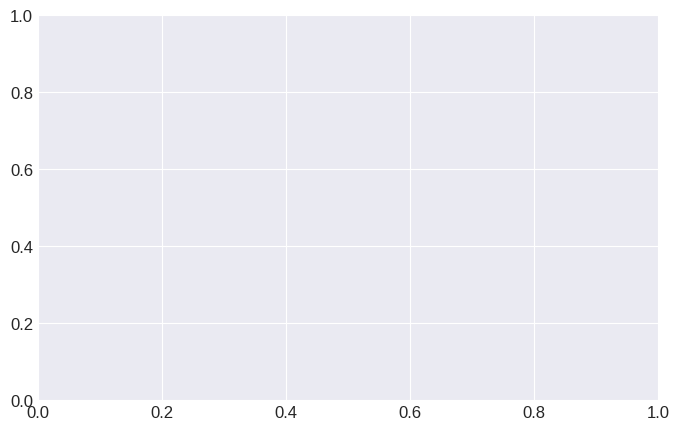

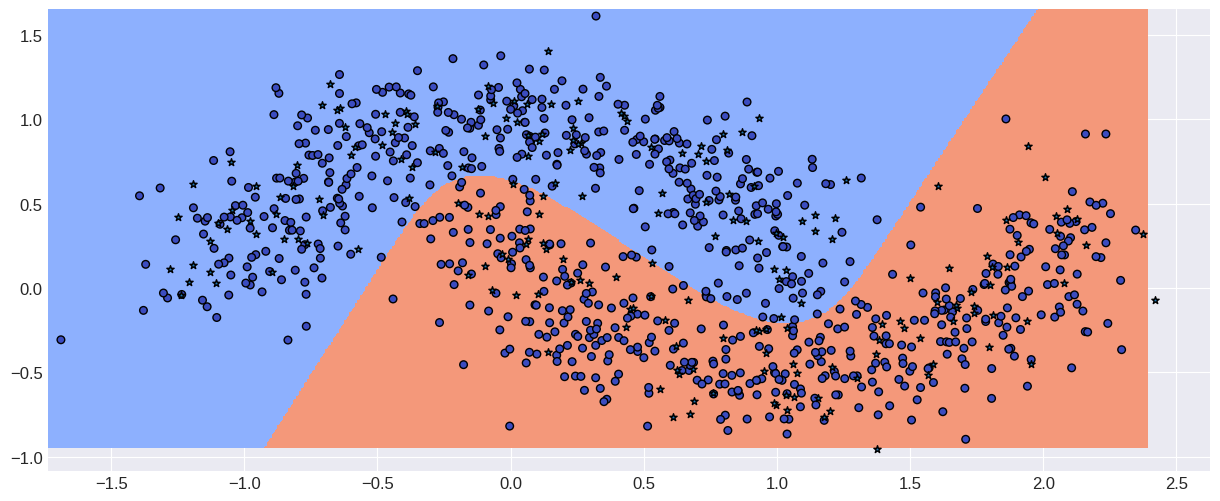

In [27]:
fn_plot_decision_boundary(lambda x:predict(model,x),X_train,y_train,X_test,y_test)